In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla
from target import GMM_target, GMM_target2, Funnel, Gaussian_target
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target(args)

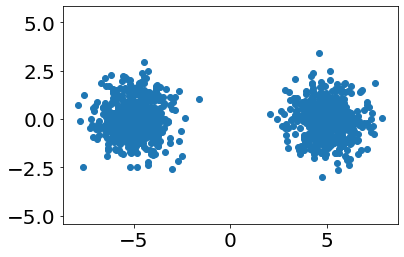

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 1000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  5%|▍         | 47/1000 [00:00<00:02, 461.60it/s]

Now we are running warmup!


  5%|▌         | 51/1000 [00:00<00:01, 504.14it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:01<00:00, 500.32it/s]


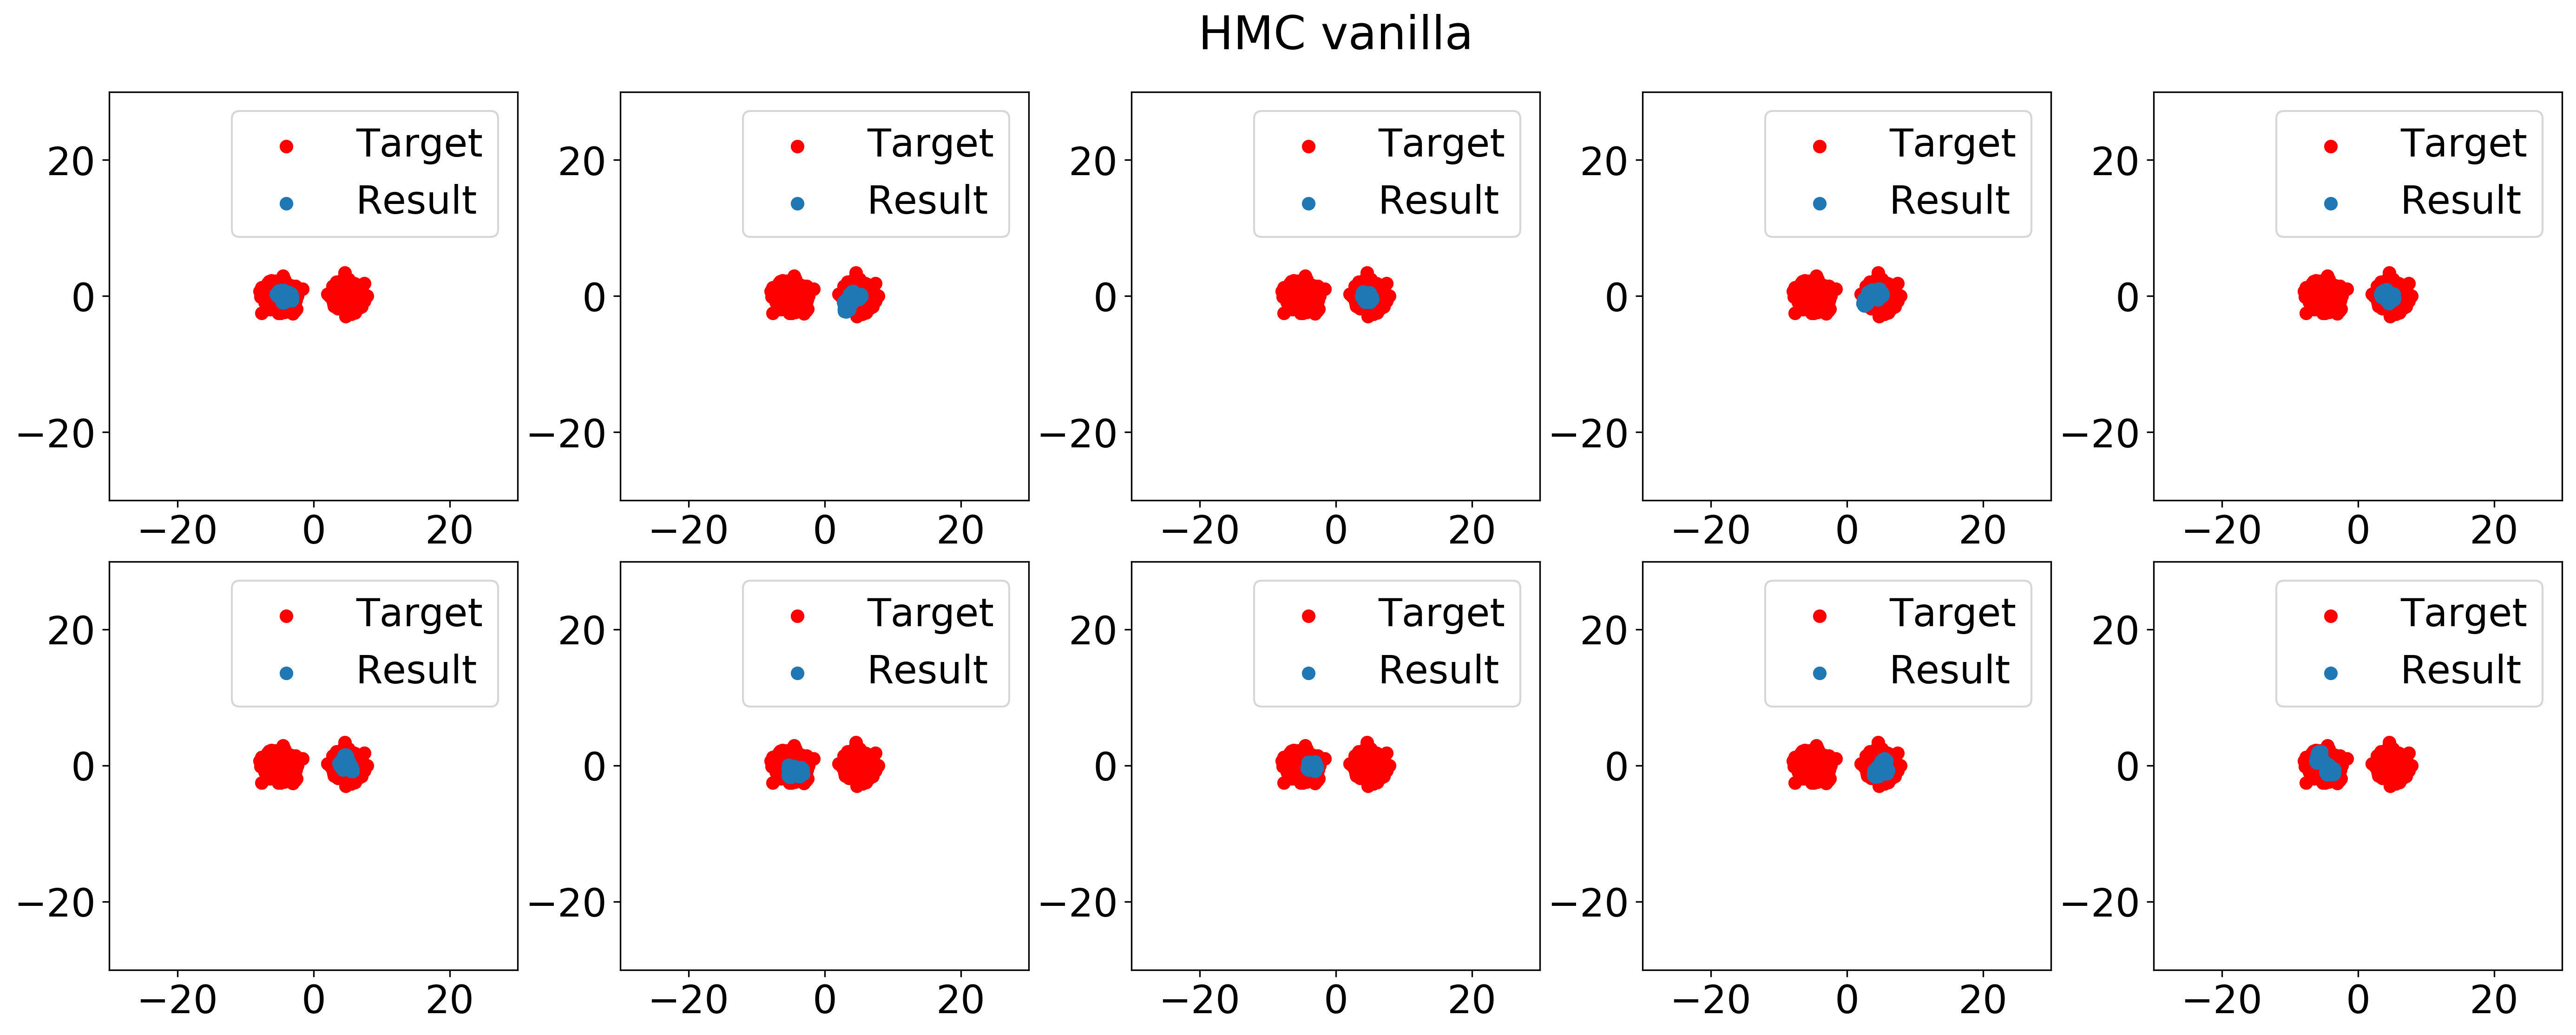

In [9]:
limit = 30
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [11]:
if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
if args.amortize:
    our_kernel = HMC_our(kwargs=args).to(args.device)
else:
    our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])

optimizer = torch.optim.Adam(params=transitions.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200)

##### Training

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.5 and for +1: 0.5
Step size for 0-th transition is 0.09999999403953552
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.504 and for +1: 0.496
Step size for 1-th transition is 0.09999999403953552
Alpha (ref) for 1-th transition is 0.5
On batch number 0 and on k = 3 we have for 0: 0.49 and for +1: 0.51
Step size for 2-th transition is 0.09999999403953552
Alpha (ref) for 2-th transition is 0.5
On batch number 0 and on k = 4 we have for 0: 0.516 and for +1: 0.484
Step size for 3-th transition is 0.09999999403953552
Alpha (ref) for 3-th transition is 0.5
On batch number 0 and on k = 5 we have for 0: 0.546 and for +1: 0.454
Step size for 4-th transition is 0.09999999403953552
Alpha (ref) for 4-th transition is 0.5


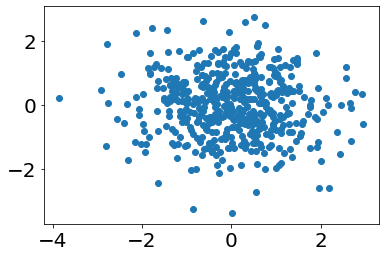

Current lr:  0.001
On batch number 0 ELBO is -12.81933879852295
On batch number 0 Best ELBO is -inf


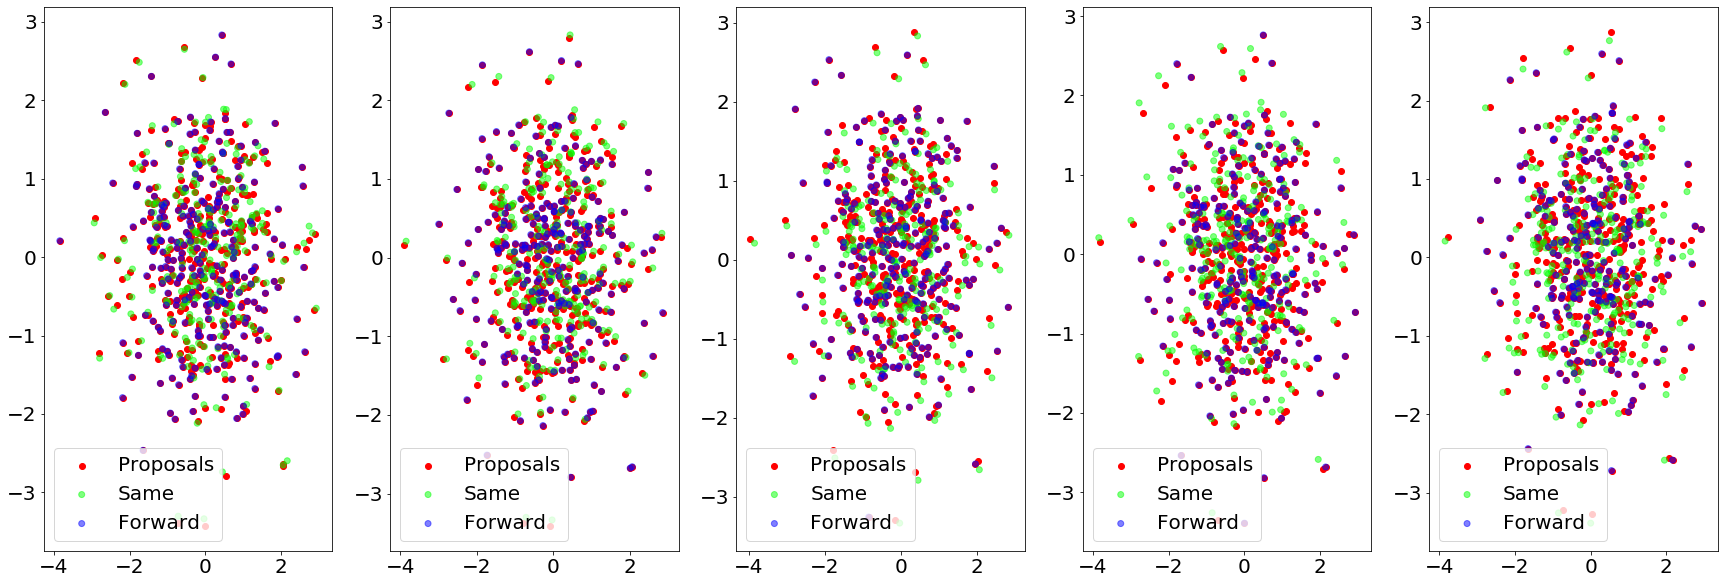

 10%|▉         | 96/1000 [00:02<00:19, 46.67it/s]

On batch number 100 and on k = 1 we have for 0: 0.474 and for +1: 0.526
Step size for 0-th transition is 0.10319574177265167
Alpha (ref) for 0-th transition is 0.4941055476665497
On batch number 100 and on k = 2 we have for 0: 0.486 and for +1: 0.514
Step size for 1-th transition is 0.10319574177265167
Alpha (ref) for 1-th transition is 0.4941055476665497
On batch number 100 and on k = 3 we have for 0: 0.52 and for +1: 0.48
Step size for 2-th transition is 0.10319574177265167
Alpha (ref) for 2-th transition is 0.4941055476665497
On batch number 100 and on k = 4 we have for 0: 0.564 and for +1: 0.436
Step size for 3-th transition is 0.10319574177265167
Alpha (ref) for 3-th transition is 0.4941055476665497
On batch number 100 and on k = 5 we have for 0: 0.488 and for +1: 0.512
Step size for 4-th transition is 0.10319574177265167
Alpha (ref) for 4-th transition is 0.4941055476665497


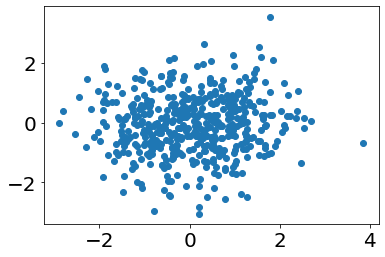

Current lr:  0.001
On batch number 100 ELBO is -12.233009338378906
On batch number 100 Best ELBO is -12.165729522705078


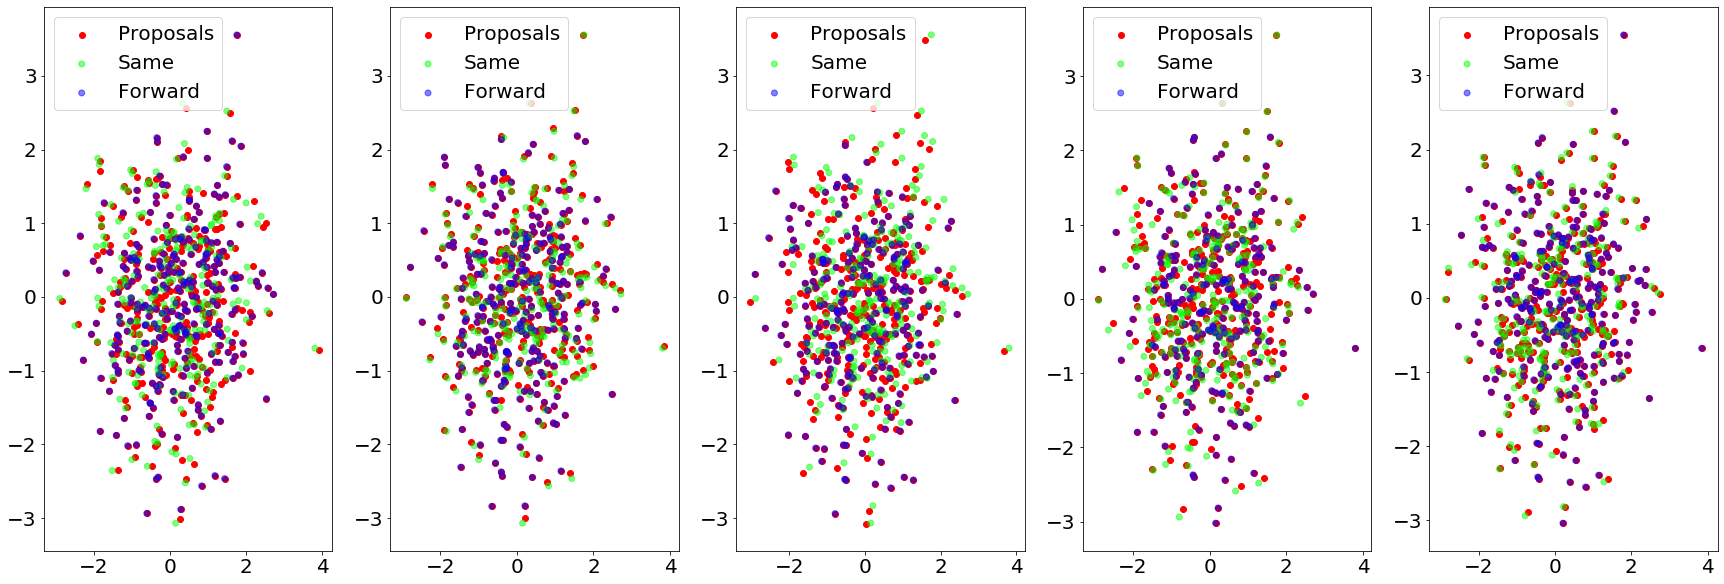

 20%|█▉        | 196/1000 [00:05<00:19, 42.01it/s]

On batch number 200 and on k = 1 we have for 0: 0.524 and for +1: 0.476
Step size for 0-th transition is 0.10586544126272202
Alpha (ref) for 0-th transition is 0.4909197986125946
On batch number 200 and on k = 2 we have for 0: 0.51 and for +1: 0.49
Step size for 1-th transition is 0.10586544126272202
Alpha (ref) for 1-th transition is 0.4909197986125946
On batch number 200 and on k = 3 we have for 0: 0.514 and for +1: 0.486
Step size for 2-th transition is 0.10586544126272202
Alpha (ref) for 2-th transition is 0.4909197986125946
On batch number 200 and on k = 4 we have for 0: 0.504 and for +1: 0.496
Step size for 3-th transition is 0.10586544126272202
Alpha (ref) for 3-th transition is 0.4909197986125946
On batch number 200 and on k = 5 we have for 0: 0.486 and for +1: 0.514
Step size for 4-th transition is 0.10586544126272202
Alpha (ref) for 4-th transition is 0.4909197986125946


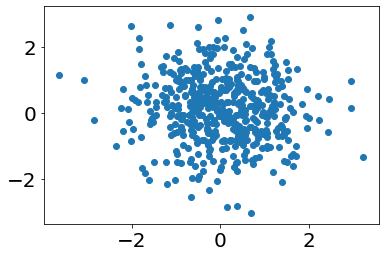

Current lr:  0.001
On batch number 200 ELBO is -12.836926460266113
On batch number 200 Best ELBO is -12.038374900817871


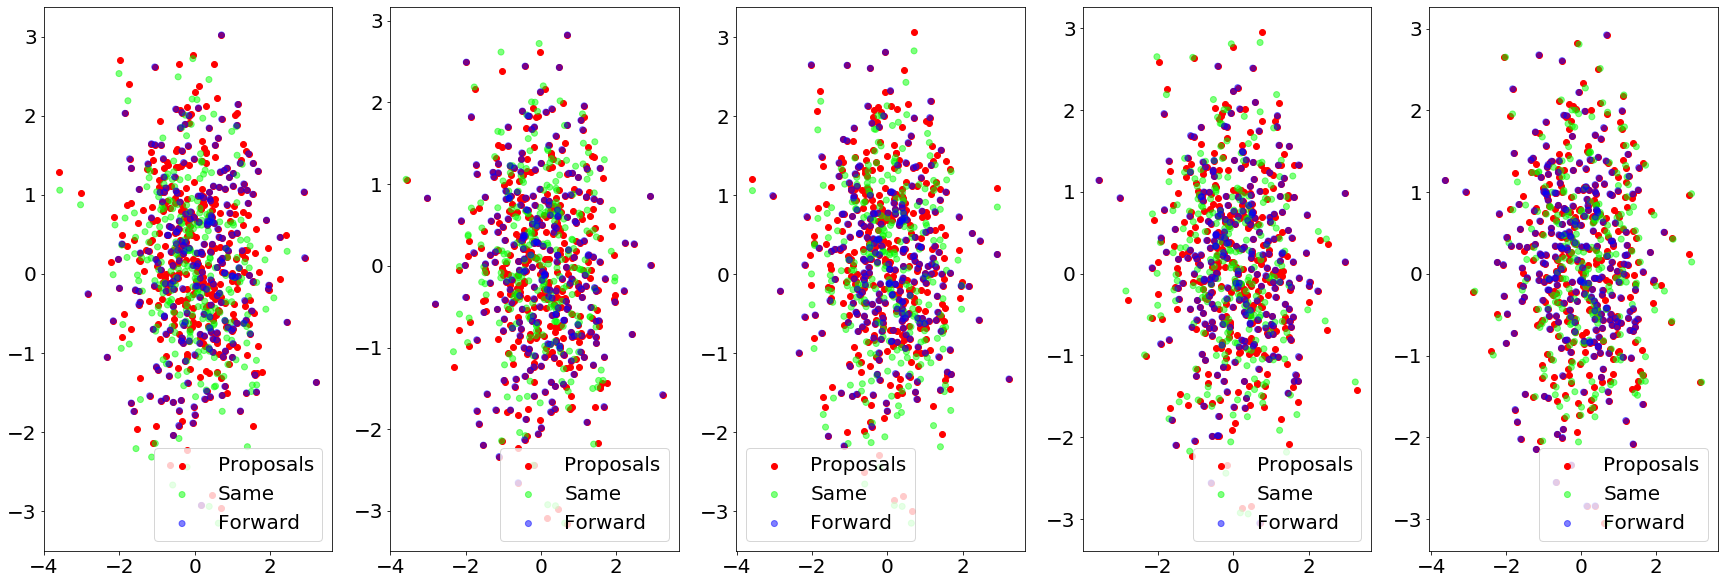

 30%|██▉       | 296/1000 [00:08<00:14, 47.89it/s]

On batch number 300 and on k = 1 we have for 0: 0.488 and for +1: 0.512
Step size for 0-th transition is 0.109095998108387
Alpha (ref) for 0-th transition is 0.48474380373954773
On batch number 300 and on k = 2 we have for 0: 0.508 and for +1: 0.492
Step size for 1-th transition is 0.109095998108387
Alpha (ref) for 1-th transition is 0.48474380373954773
On batch number 300 and on k = 3 we have for 0: 0.484 and for +1: 0.516
Step size for 2-th transition is 0.109095998108387
Alpha (ref) for 2-th transition is 0.48474380373954773
On batch number 300 and on k = 4 we have for 0: 0.466 and for +1: 0.534
Step size for 3-th transition is 0.109095998108387
Alpha (ref) for 3-th transition is 0.48474380373954773
On batch number 300 and on k = 5 we have for 0: 0.478 and for +1: 0.522
Step size for 4-th transition is 0.109095998108387
Alpha (ref) for 4-th transition is 0.48474380373954773


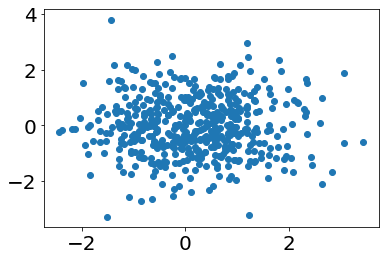

Current lr:  0.001
On batch number 300 ELBO is -12.563162803649902
On batch number 300 Best ELBO is -12.038374900817871


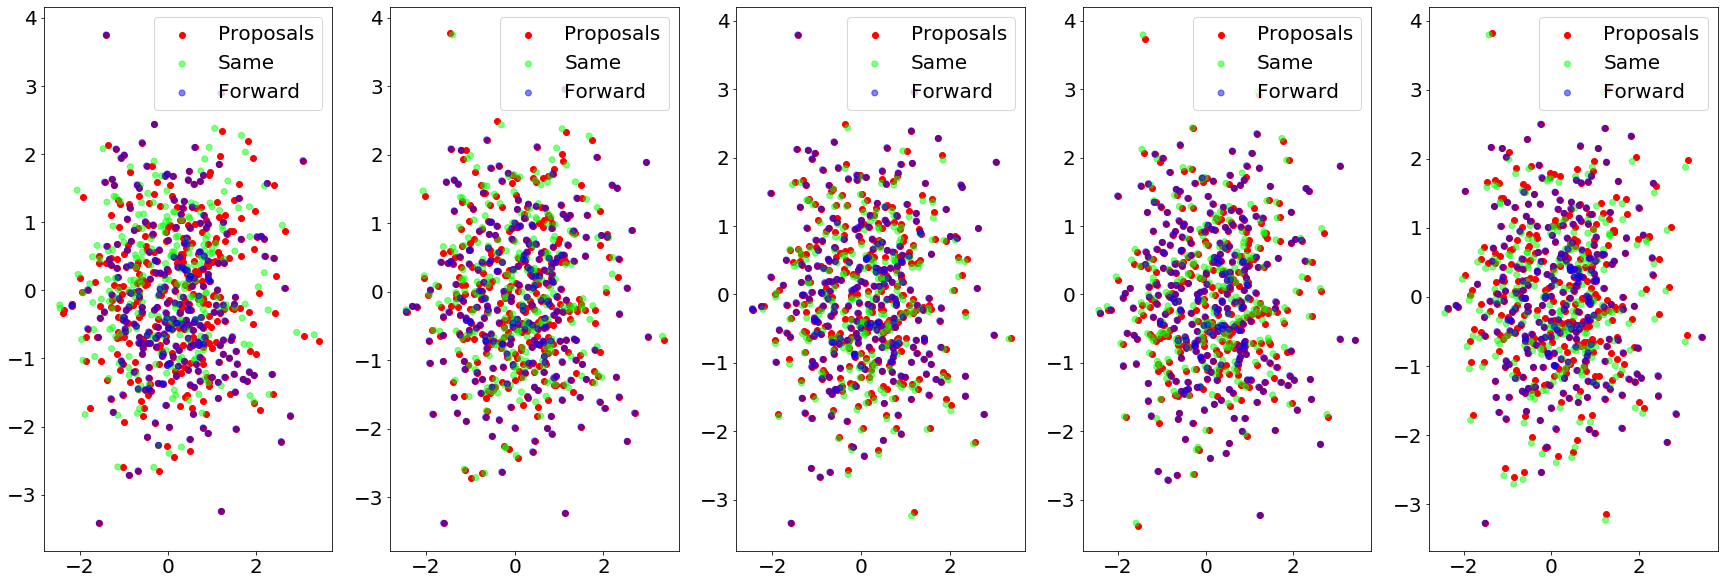

 40%|███▉      | 396/1000 [00:11<00:14, 42.08it/s]

On batch number 400 and on k = 1 we have for 0: 0.526 and for +1: 0.474
Step size for 0-th transition is 0.11166080087423325
Alpha (ref) for 0-th transition is 0.4826051592826843
On batch number 400 and on k = 2 we have for 0: 0.512 and for +1: 0.488
Step size for 1-th transition is 0.11166080087423325
Alpha (ref) for 1-th transition is 0.4826051592826843
On batch number 400 and on k = 3 we have for 0: 0.52 and for +1: 0.48
Step size for 2-th transition is 0.11166080087423325
Alpha (ref) for 2-th transition is 0.4826051592826843
On batch number 400 and on k = 4 we have for 0: 0.476 and for +1: 0.524
Step size for 3-th transition is 0.11166080087423325
Alpha (ref) for 3-th transition is 0.4826051592826843
On batch number 400 and on k = 5 we have for 0: 0.496 and for +1: 0.504
Step size for 4-th transition is 0.11166080087423325
Alpha (ref) for 4-th transition is 0.4826051592826843


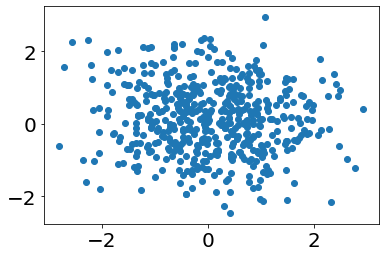

Current lr:  0.0001
On batch number 400 ELBO is -12.661320686340332
On batch number 400 Best ELBO is -12.038374900817871


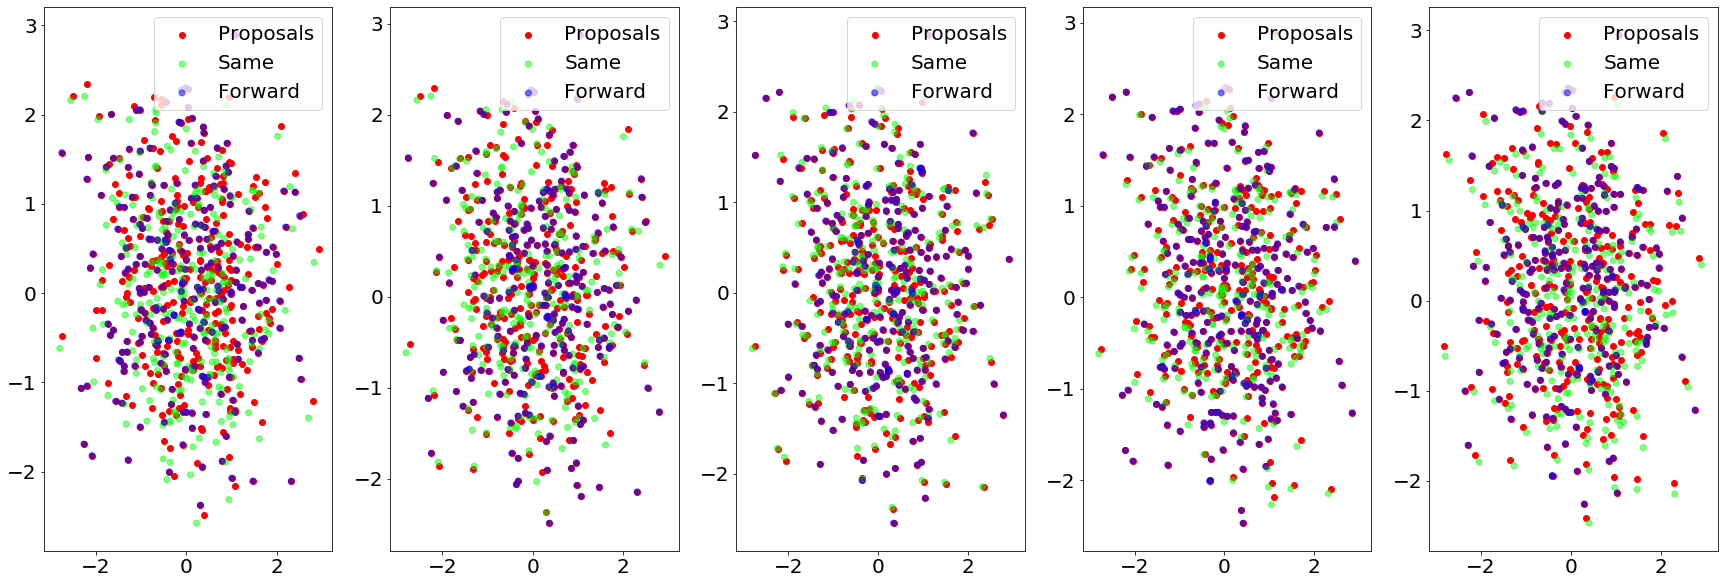

 50%|█████     | 500/1000 [00:15<00:11, 41.78it/s]

On batch number 500 and on k = 1 we have for 0: 0.488 and for +1: 0.512
Step size for 0-th transition is 0.11177586764097214
Alpha (ref) for 0-th transition is 0.4822184145450592
On batch number 500 and on k = 2 we have for 0: 0.51 and for +1: 0.49
Step size for 1-th transition is 0.11177586764097214
Alpha (ref) for 1-th transition is 0.4822184145450592
On batch number 500 and on k = 3 we have for 0: 0.518 and for +1: 0.482
Step size for 2-th transition is 0.11177586764097214
Alpha (ref) for 2-th transition is 0.4822184145450592
On batch number 500 and on k = 4 we have for 0: 0.504 and for +1: 0.496
Step size for 3-th transition is 0.11177586764097214
Alpha (ref) for 3-th transition is 0.4822184145450592
On batch number 500 and on k = 5 we have for 0: 0.516 and for +1: 0.484
Step size for 4-th transition is 0.11177586764097214
Alpha (ref) for 4-th transition is 0.4822184145450592


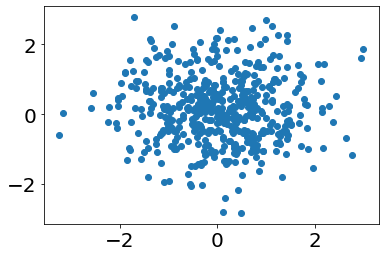

Current lr:  0.0001
On batch number 500 ELBO is -13.207880973815918
On batch number 500 Best ELBO is -12.038374900817871


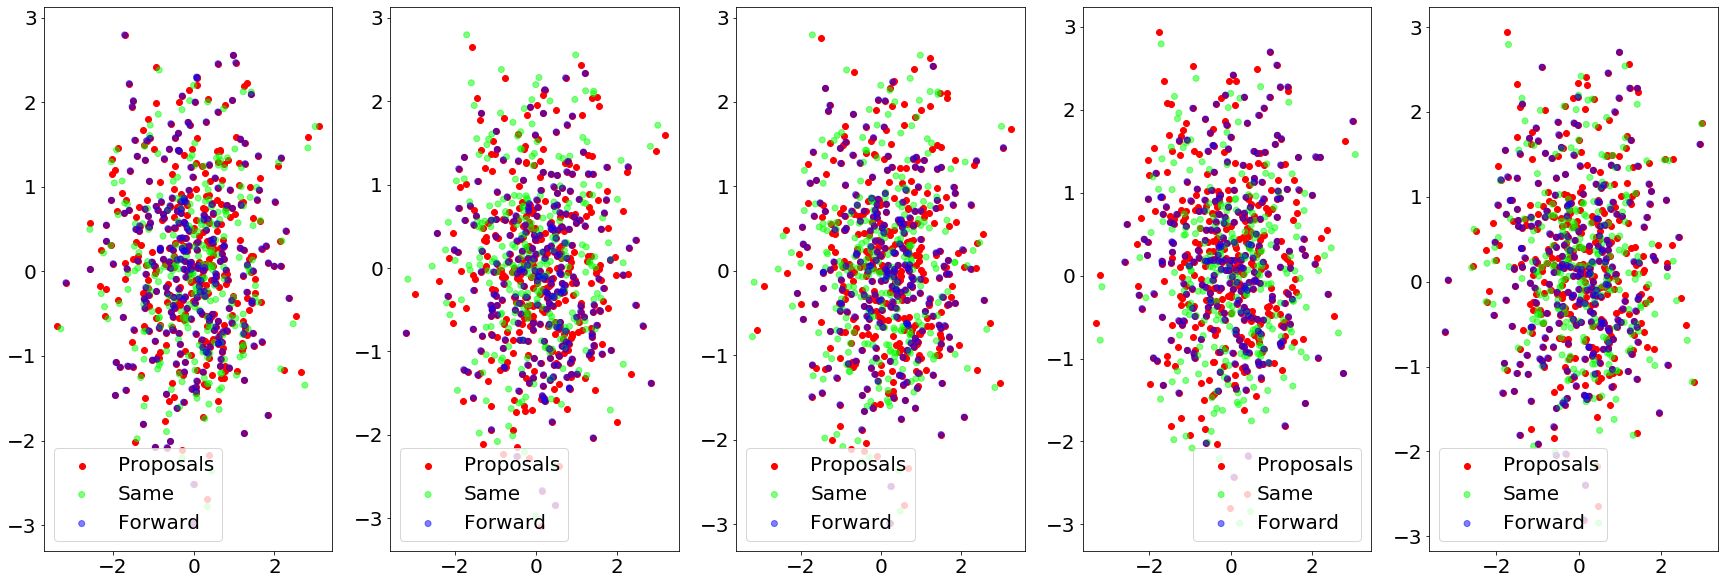

 60%|██████    | 600/1000 [00:18<00:09, 41.25it/s]

On batch number 600 and on k = 1 we have for 0: 0.478 and for +1: 0.522
Step size for 0-th transition is 0.11200352013111115
Alpha (ref) for 0-th transition is 0.48154574632644653
On batch number 600 and on k = 2 we have for 0: 0.502 and for +1: 0.498
Step size for 1-th transition is 0.11200352013111115
Alpha (ref) for 1-th transition is 0.48154574632644653
On batch number 600 and on k = 3 we have for 0: 0.462 and for +1: 0.538
Step size for 2-th transition is 0.11200352013111115
Alpha (ref) for 2-th transition is 0.48154574632644653
On batch number 600 and on k = 4 we have for 0: 0.512 and for +1: 0.488
Step size for 3-th transition is 0.11200352013111115
Alpha (ref) for 3-th transition is 0.48154574632644653
On batch number 600 and on k = 5 we have for 0: 0.51 and for +1: 0.49
Step size for 4-th transition is 0.11200352013111115
Alpha (ref) for 4-th transition is 0.48154574632644653


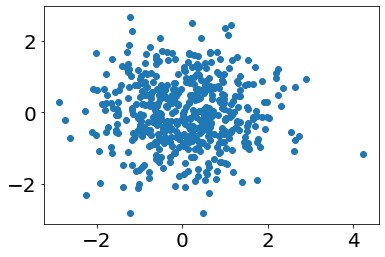

Current lr:  1e-05
On batch number 600 ELBO is -13.441832542419434
On batch number 600 Best ELBO is -12.038374900817871


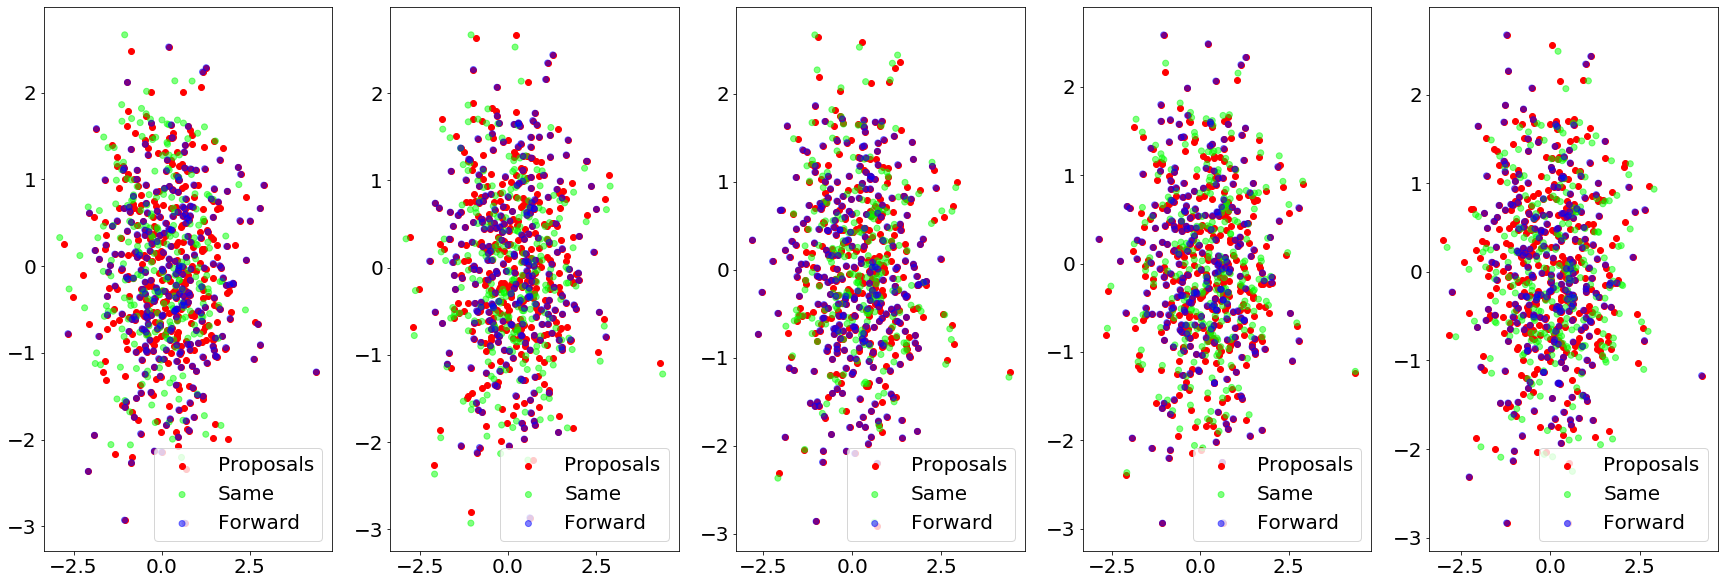

 70%|███████   | 700/1000 [00:21<00:07, 42.08it/s]

On batch number 700 and on k = 1 we have for 0: 0.492 and for +1: 0.508
Step size for 0-th transition is 0.11203618347644806
Alpha (ref) for 0-th transition is 0.4814911484718323
On batch number 700 and on k = 2 we have for 0: 0.496 and for +1: 0.504
Step size for 1-th transition is 0.11203618347644806
Alpha (ref) for 1-th transition is 0.4814911484718323
On batch number 700 and on k = 3 we have for 0: 0.53 and for +1: 0.47
Step size for 2-th transition is 0.11203618347644806
Alpha (ref) for 2-th transition is 0.4814911484718323
On batch number 700 and on k = 4 we have for 0: 0.436 and for +1: 0.564
Step size for 3-th transition is 0.11203618347644806
Alpha (ref) for 3-th transition is 0.4814911484718323
On batch number 700 and on k = 5 we have for 0: 0.514 and for +1: 0.486
Step size for 4-th transition is 0.11203618347644806
Alpha (ref) for 4-th transition is 0.4814911484718323


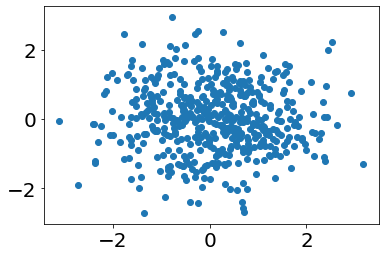

Current lr:  1e-05
On batch number 700 ELBO is -12.42221736907959
On batch number 700 Best ELBO is -12.035551071166992


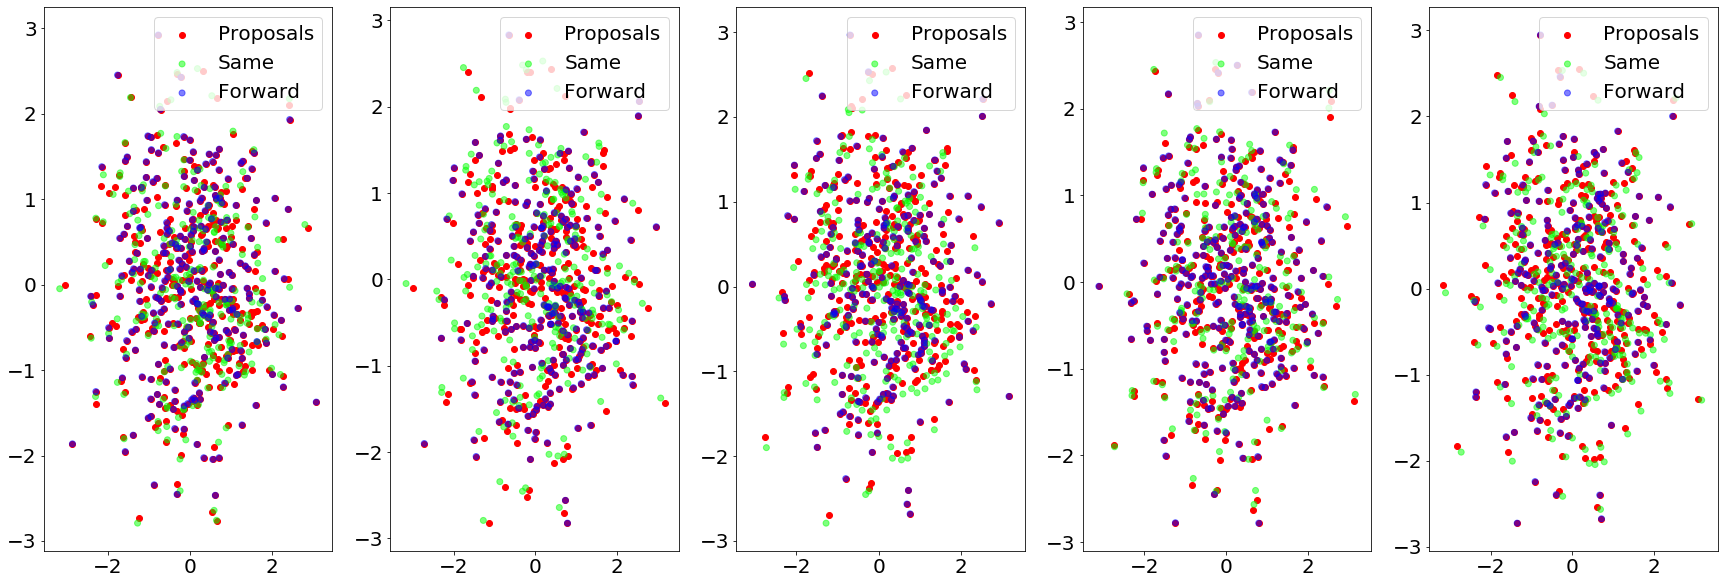

 80%|████████  | 800/1000 [00:24<00:04, 48.57it/s]

On batch number 800 and on k = 1 we have for 0: 0.466 and for +1: 0.534
Step size for 0-th transition is 0.11205395311117172
Alpha (ref) for 0-th transition is 0.4814506769180298
On batch number 800 and on k = 2 we have for 0: 0.472 and for +1: 0.528
Step size for 1-th transition is 0.11205395311117172
Alpha (ref) for 1-th transition is 0.4814506769180298
On batch number 800 and on k = 3 we have for 0: 0.484 and for +1: 0.516
Step size for 2-th transition is 0.11205395311117172
Alpha (ref) for 2-th transition is 0.4814506769180298
On batch number 800 and on k = 4 we have for 0: 0.52 and for +1: 0.48
Step size for 3-th transition is 0.11205395311117172
Alpha (ref) for 3-th transition is 0.4814506769180298
On batch number 800 and on k = 5 we have for 0: 0.462 and for +1: 0.538
Step size for 4-th transition is 0.11205395311117172
Alpha (ref) for 4-th transition is 0.4814506769180298


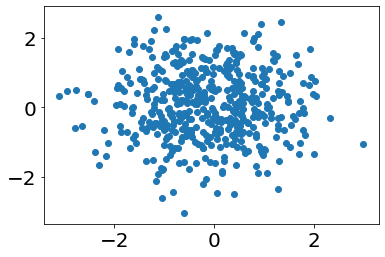

Current lr:  1e-05
On batch number 800 ELBO is -12.918691635131836
On batch number 800 Best ELBO is -12.035551071166992


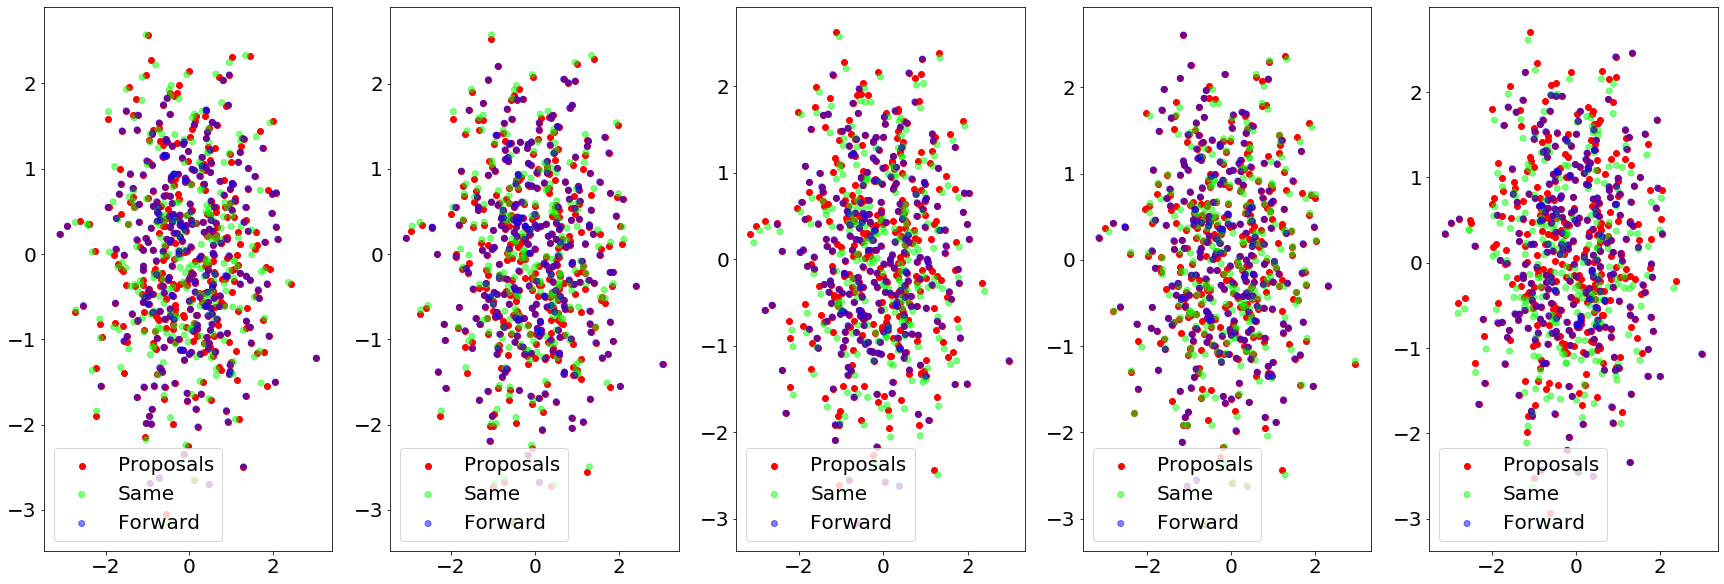

 90%|█████████ | 900/1000 [00:27<00:02, 41.43it/s]

On batch number 900 and on k = 1 we have for 0: 0.502 and for +1: 0.498
Step size for 0-th transition is 0.11207278817892075
Alpha (ref) for 0-th transition is 0.4814165234565735
On batch number 900 and on k = 2 we have for 0: 0.49 and for +1: 0.51
Step size for 1-th transition is 0.11207278817892075
Alpha (ref) for 1-th transition is 0.4814165234565735
On batch number 900 and on k = 3 we have for 0: 0.508 and for +1: 0.492
Step size for 2-th transition is 0.11207278817892075
Alpha (ref) for 2-th transition is 0.4814165234565735
On batch number 900 and on k = 4 we have for 0: 0.504 and for +1: 0.496
Step size for 3-th transition is 0.11207278817892075
Alpha (ref) for 3-th transition is 0.4814165234565735
On batch number 900 and on k = 5 we have for 0: 0.484 and for +1: 0.516
Step size for 4-th transition is 0.11207278817892075
Alpha (ref) for 4-th transition is 0.4814165234565735


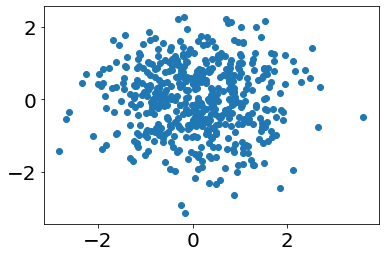

Current lr:  1.0000000000000002e-06
On batch number 900 ELBO is -13.243375778198242
On batch number 900 Best ELBO is -12.035551071166992


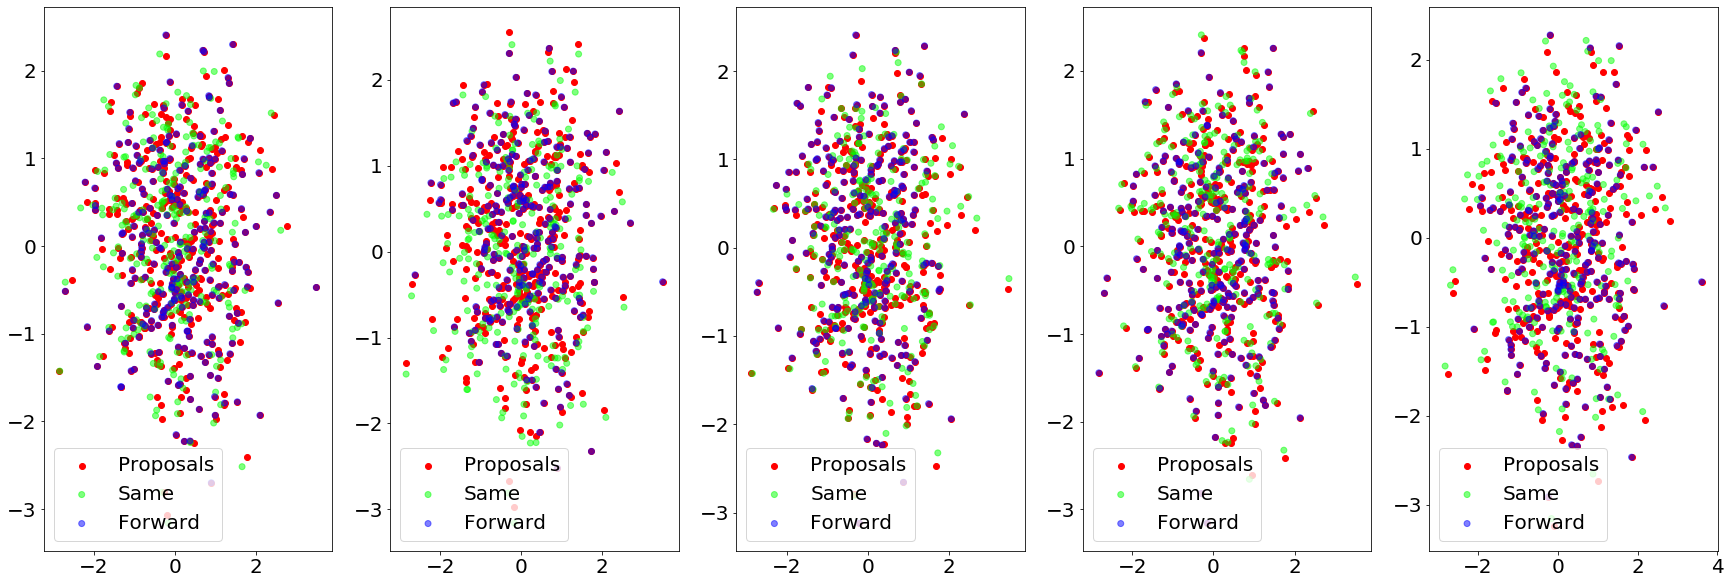

100%|██████████| 1000/1000 [00:30<00:00, 32.78it/s]


In [11]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(z, p, z_old, p_old, current_log_alphas, log_jac):
    log_p = target.get_logdensity(z=z) + args.std_normal.log_prob(p).sum(1)
    log_r = -args.K * torch_log_2
    log_m = args.std_normal.log_prob(z_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - log_jac + current_log_alphas
    elbo_full = log_p + log_r - log_m
    current_grad = torch.mean(log_p + (current_log_alphas + args.std_normal.log_prob(z_old).sum(1)) * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), current_grad

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    q = q_old.detach()
    p = p_old.detach()
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
    # run training cycle
    sum_grad = 0.
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q.detach(),
                                                        p_old=p.detach(), k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q.detach(),
                                                        p_old=p.detach(), k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            if args.amortize:
                print('Step size for {}-th transition is {}'.format(k, transitions.gamma.detach().exp()))
                print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions.alpha_logit.detach())))               
            else:
                print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
                print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))

        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        elbo_full, current_grad = compute_loss(z=q, p=p, z_old=q_old, p_old=p_old,
                                current_log_alphas=current_log_alphas, log_jac=log_jac)
        sum_grad += current_grad
        
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
        label = ['Same', 'Forward']
        for kk in range(args.K):
            ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
            for d in [0., 1.]:
                z_c = array_z[kk][array_directions[kk]==d]
                alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
                color = np.zeros((z_c.shape[0], 4))
                color[:, 3] = alpha_c
                color[:, int(d + 1)] = 1.
                ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
                ax[kk].legend()
        plt.show();
    (-sum_grad).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [12]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [13]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        if args.amortize:
            q_new, p_new, _, _, _, _ = our_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                               k=cond_vectors[k])
        else:
            q_new, p_new, _, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                       k=cond_vectors[k])
iterator.close()
    
samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        if args.amortize:
            q_new, p_new, _, _, a, _ = our_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                               k=cond_vectors[k])
        else:
            q_new, p_new, _, _, a, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                           k=cond_vectors[k])
        samples_our[i] = q_new.detach()
iterator.close()

  1%|          | 2/200 [00:00<00:11, 17.15it/s]

Now we are running warmup!


  4%|▍         | 9/200 [00:00<00:02, 88.88it/s]

Now we are sampling!


100%|██████████| 200/200 [00:02<00:00, 87.37it/s]


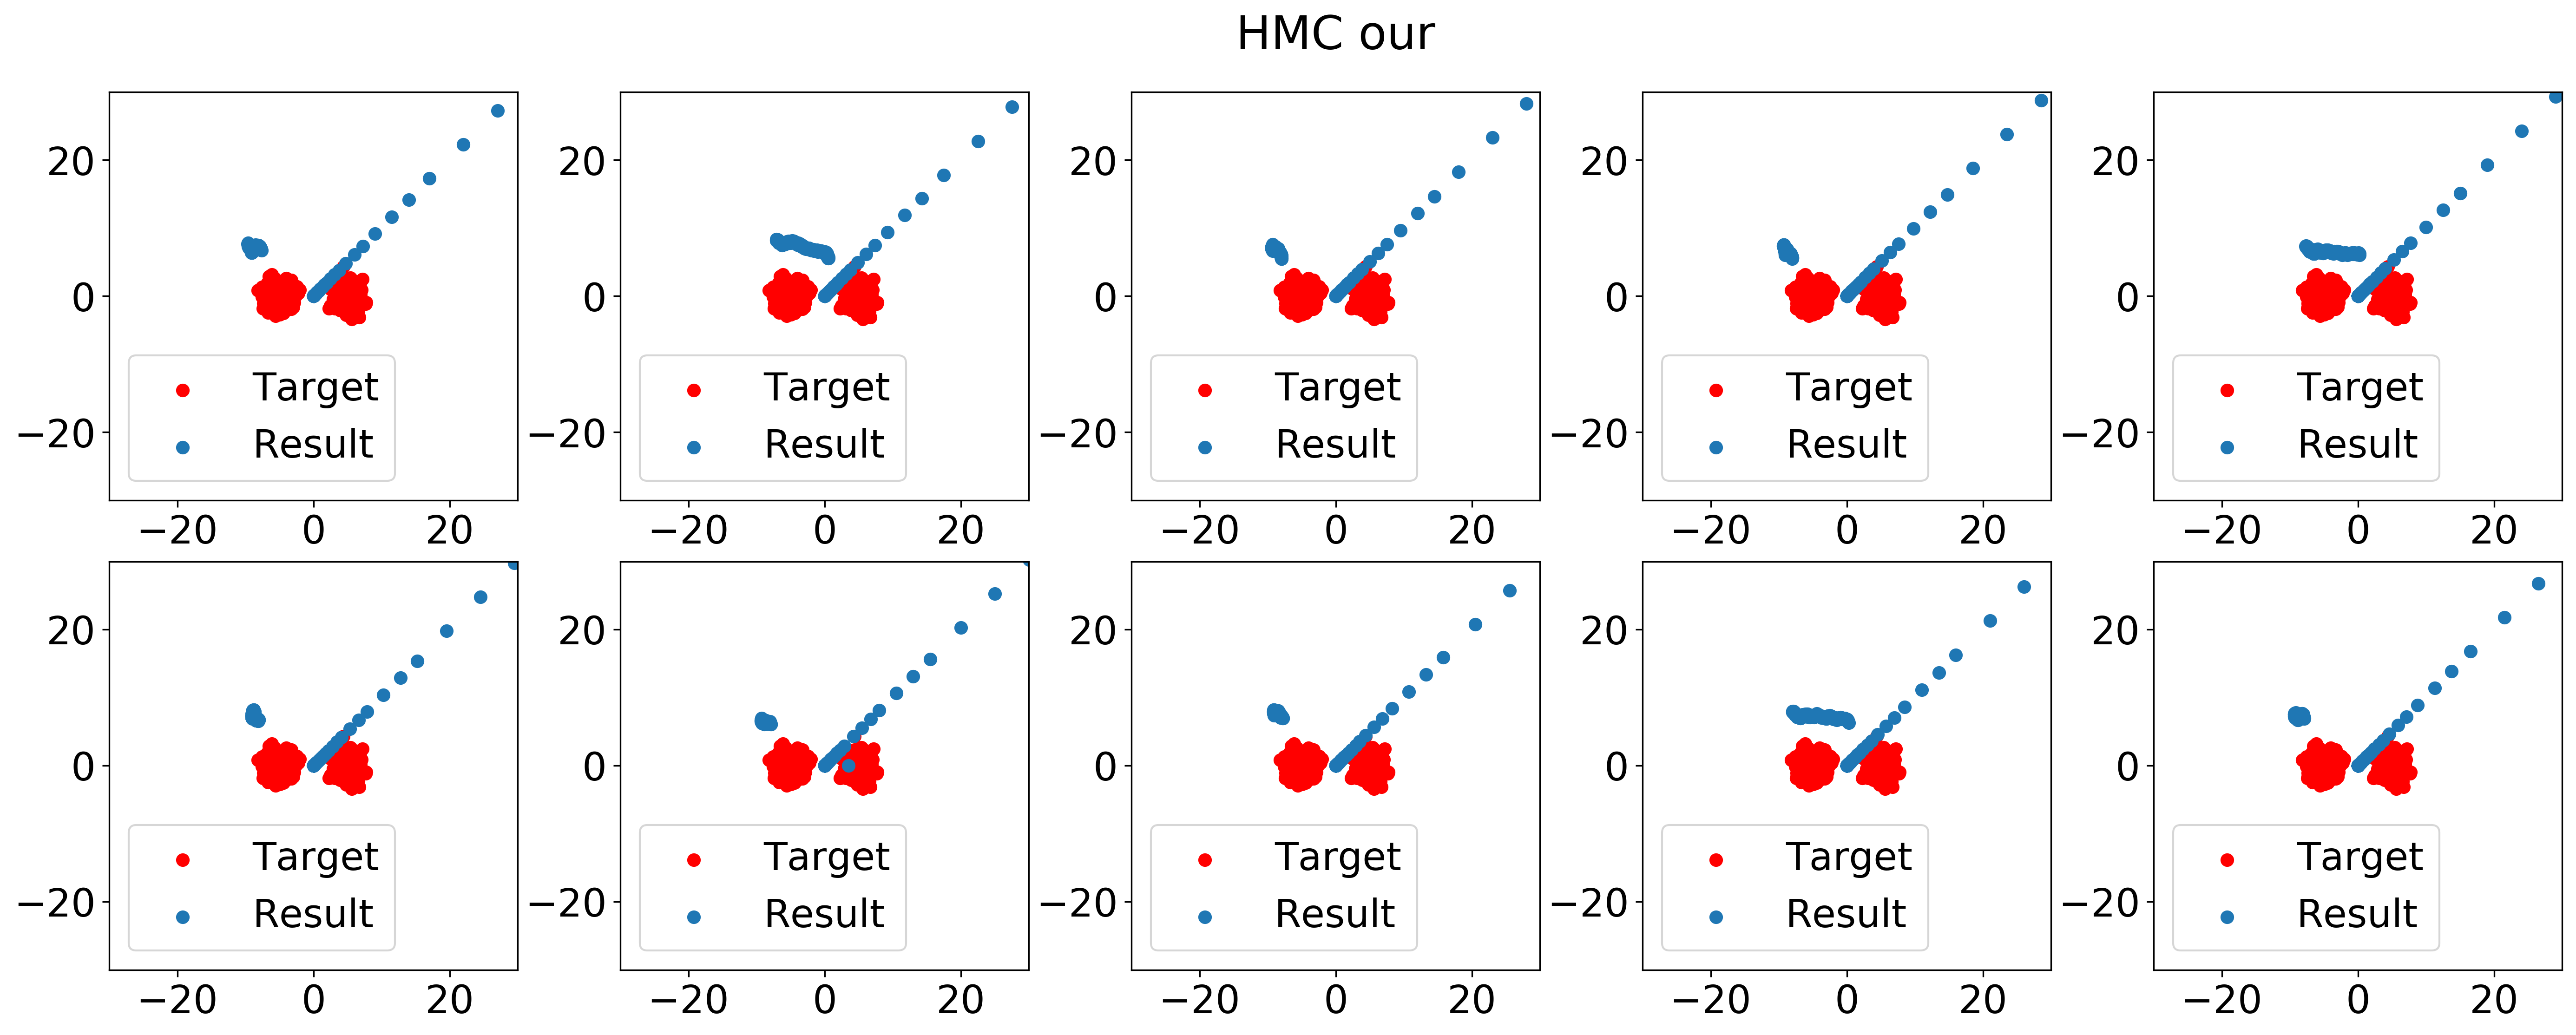

In [14]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC our')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [15]:
# n_samples = 10000
n_chains = 10
repetitions = 1000

init_q = args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True)
q = init_q
our_samples = []
our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
    for k in range(args.K):
        if args.amortize:
            q, p, _, _, _, _ = our_kernel.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, _, _, _, _ = our_kernel[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [16]:
our_samples = np.array(our_samples)

In [17]:
our_samples.shape

(5001, 10, 2)

In [18]:
target_samples = target.get_samples(q.shape[0])

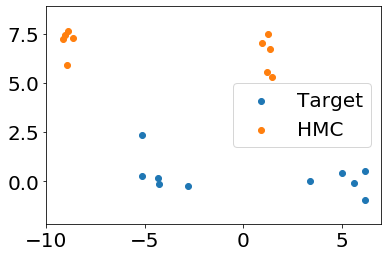

In [19]:
plt.scatter(target_samples[:, 0].cpu().detach().numpy(), target_samples[:, 1].cpu().detach().numpy(), label='Target')
plt.scatter(q[:, 0].cpu().detach().numpy(), q[:, 1].cpu().detach().numpy(), label='HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();